In [1]:
%load_ext autoreload
%autoreload 2
import LCN_model
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from tqdm import tqdm

## Precision test

In [28]:
np.random.seed(1)
torch.manual_seed(1)
net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)#.to(net.device)
x = net.inputting(-np.pi/36, np.pi/36, random_sf = False)
y = net.desired_outputting()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(2000, optimizer)

net2 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
x = net2.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = net2.desired_outputting()
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.mean_train(2000, optimizer)

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [31]:
np.random.seed(1)
torch.manual_seed(1)
net3 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(1000, optimizer, np.pi/36, np.pi/180, np.pi/16, 2)

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


In [32]:
torch.save(net.state_dict(), "Low_precision_model.pt")
torch.save(net.losses, "Low_precision_model_loss.pt")
torch.save(net.training_scores, "Low_precisions_model_performance.pt")
torch.save(net.before_v1weights, "Low_precision_model_v1_weight_change.pt")
torch.save(net.before_v4weights, "Low_precision_model_v4_weight_change.pt")
torch.save(net.before_decision_weights, "Low_precision_model_decision_weight_change.pt")

torch.save(net2.state_dict(), "High_precision_model.pt")
torch.save(net2.losses, "High_precision_model_loss.pt")
torch.save(net2.training_scores, "High_precision_model_performance.pt")
torch.save(net2.before_v1weights, "High_precision_model_v1_weight_change.pt")
torch.save(net2.before_v4weights, "High_precision_model_v4_weight_change.pt")
torch.save(net2.before_decision_weights, "High_precision_model_decision_weight_change.pt")

torch.save(net3.state_dict(), "Sequential_model.pt")
torch.save(net3.losses, "Sequential_model_loss.pt")
torch.save(net3.training_scores, "Sequential_model_performance.pt")
torch.save(net3.generalize_error, "Sequential_model_generalization_loss.pt")
torch.save(net3.generalize_perform, "Sequential_model_generalization_perform.pt")
torch.save(net3.before_v1weights, "Sequential_model_v1_weight_change.pt")
torch.save(net3.before_v4weights, "Sequential_model_v4_weight_change.pt")
torch.save(net3.before_decision_weights, "Sequential_model_decision_weight_change.pt")

In [ ]:
net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6,
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
net.load_state_dict(torch.load("Low_precision_model.pt"))
net.losses = torch.load("Low_precision_model_loss.pt")
net.training_scores = torch.load("Low_precision_model_performance.pt")
net.before_v1weights = torch.load("Low_precision_model_v1_weight_change.pt")
net.before_v4weights = torch.load("Low_precision_model_v4_weight_change.pt")
net.before_decision_weights = torch.load("Low_precision_model_decision_weight_change.pt")
net.v1_tuning_curve()
net.v4_tuning_curve()

net2 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
net2.load_state_dict(torch.load("High_precision_model.pt"))
net2.losses = torch.load("High_precision_model_loss.pt")
net2.training_scores = torch.load("High_precision_model_performance.pt")
net2.before_v1weights = torch.load("High_precision_model_v1_weight_change.pt")
net2.before_v4weights = torch.load("High_precision_model_v4_weight_change.pt")
net2.before_decision_weights = torch.load("High_precision_model_decision_weight_change.pt")
net2.v1_tuning_curve()
net2.v4_tuning_curve()

net3 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.load_state_dict(torch.load("Sequential_model.pt"))
net3.losses = torch.load("Sequential_model_loss.pt")
net3.training_scores = torch.load("Sequential_model_performance.pt")
net3.generalize_error = torch.load("Sequential_model_generalization_loss.pt")
net3.generalize_perform = torch.load("Sequential_model_generalization_perform.pt")
net3.before_v1weights = torch.load("Sequential_model_v1_weight_change.pt")
net3.before_v4weights = torch.load("Sequential_model_v4_weight_change.pt")
net3.before_decision_weights = torch.load("Sequential_model_decision_weight_change.pt")
net3.v1_tuning_curve()
net3.v4_tuning_curve()

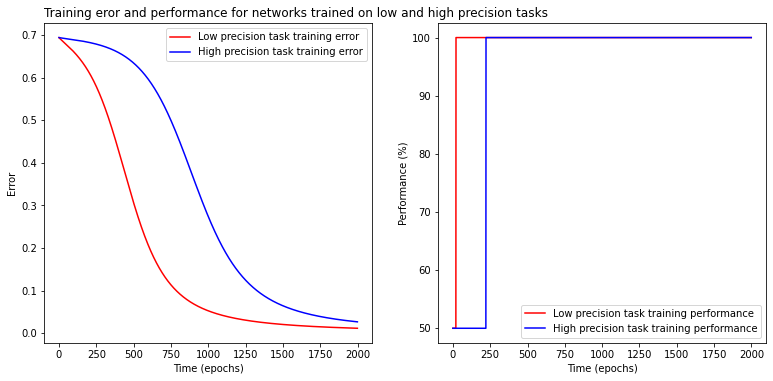

In [30]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_training_error('red')
net2.plot_training_error('blue')
plt.legend(["Low precision task training error",
            "High precision task training error"]);
plt.title("Training eror and performance for networks trained on low and high precision tasks", loc = "left")

plt.subplot(3, 3, 2)
net.plot_training_performance('red')
net2.plot_training_performance('blue')
plt.legend(["Low precision task training performance",
            "High precision task training performance"]);


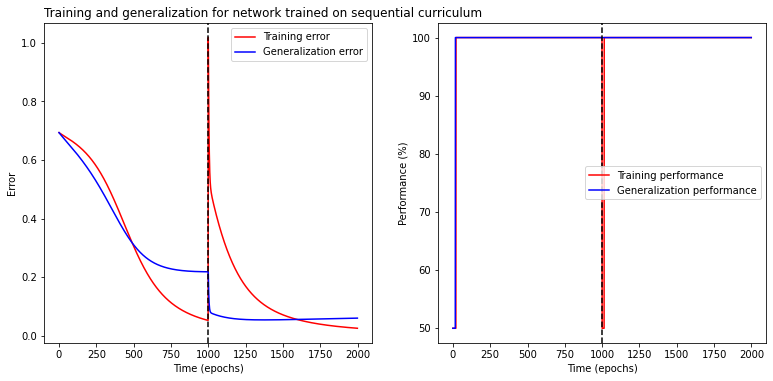

In [34]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(1000, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(1000, 0, 1, linestyle = 'dashed', color = 'black');


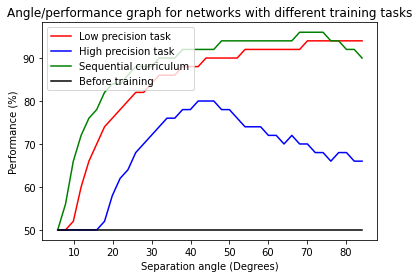

In [35]:
net4 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
net.plot_angle_performance(40, 'red')
net2.plot_angle_performance(40, 'blue')
net3.plot_angle_performance(40, 'green')
net4.plot_angle_performance(40, 'black')
plt.title("Angle/performance graph for networks with different training tasks");
plt.legend(["Low precision task", "High precision task", "Sequential curriculum", "Before training"]);

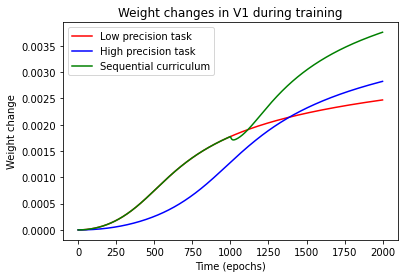

In [36]:
net.plot_weight_change('red', v1 = True)
net2.plot_weight_change('blue', v1 = True)
net3.plot_weight_change('green', v1 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in V1 during training");

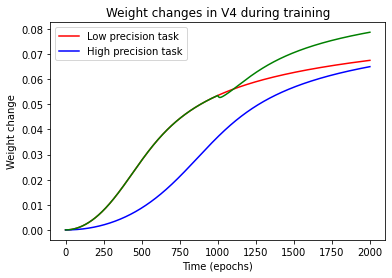

In [37]:
net.plot_weight_change('red', v4 = True)
net2.plot_weight_change('blue', v4 = True)
net3.plot_weight_change('green', v4 = True)
plt.legend(["Low precision task", "High precision task"]);
plt.title("Weight changes in V4 during training");

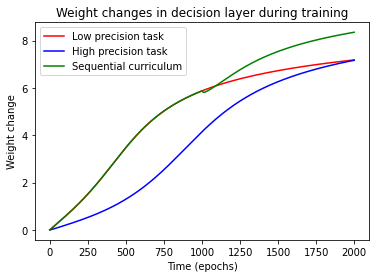

In [38]:
net.plot_weight_change('red', decision = True)
net2.plot_weight_change('blue', decision = True)
net3.plot_weight_change('green', decision = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in decision layer during training");

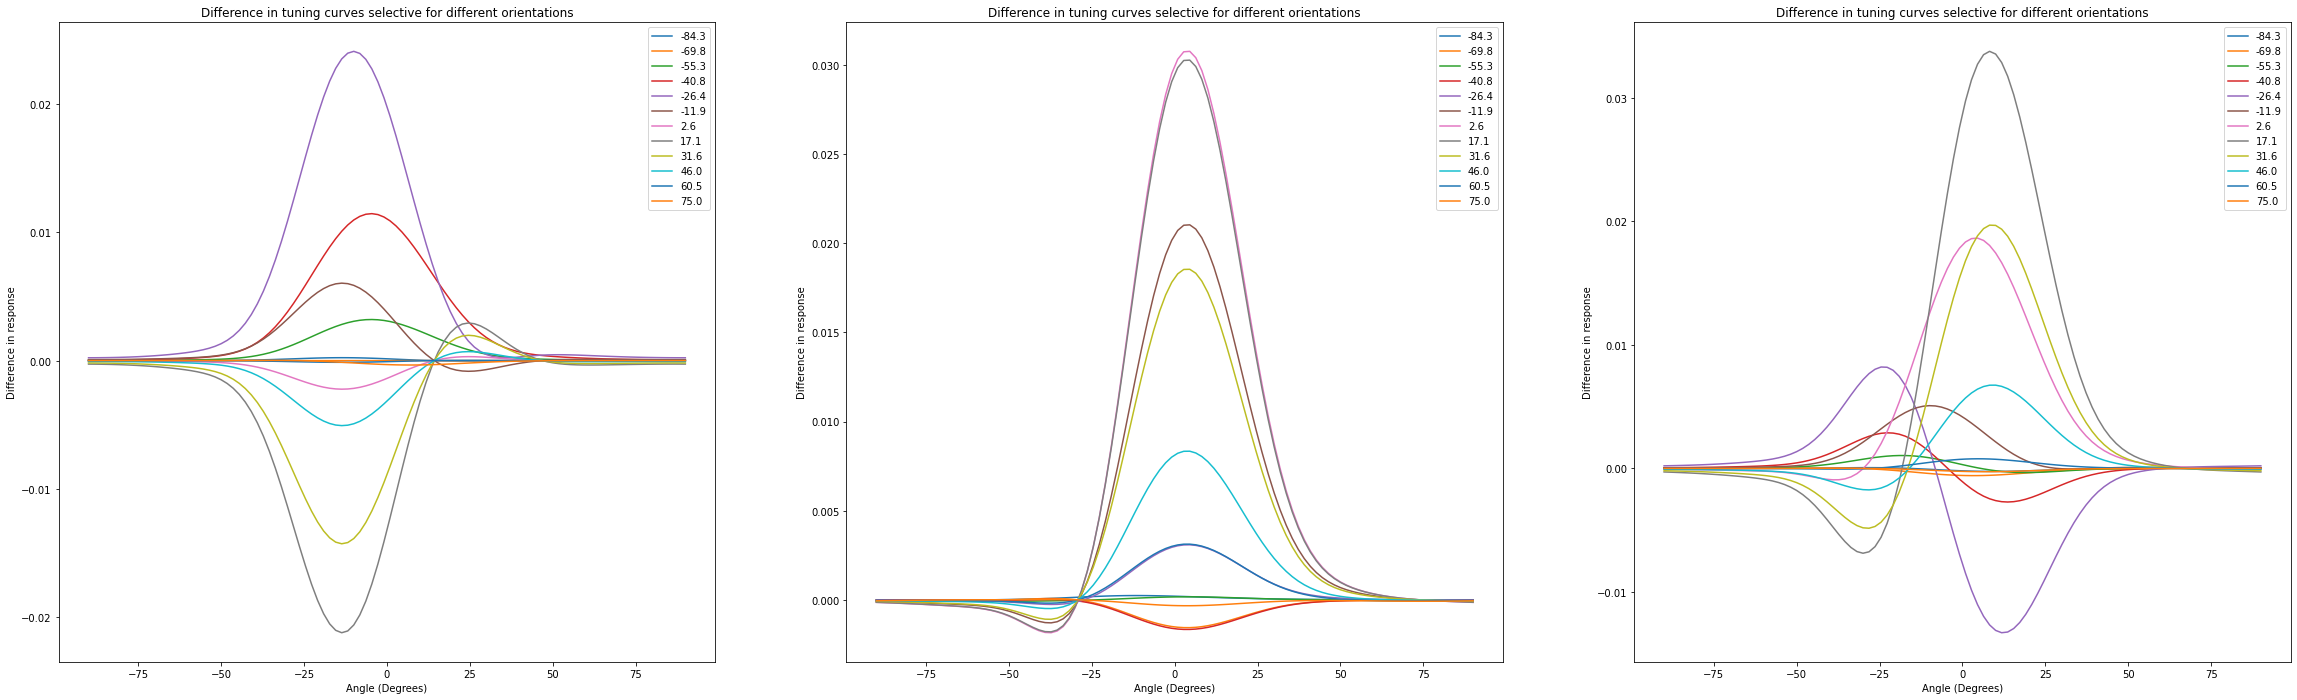

In [39]:
plt.figure(figsize = [40, 40])
plt.subplot(3, 3, 1)
net.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
net2.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 3)
net3.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

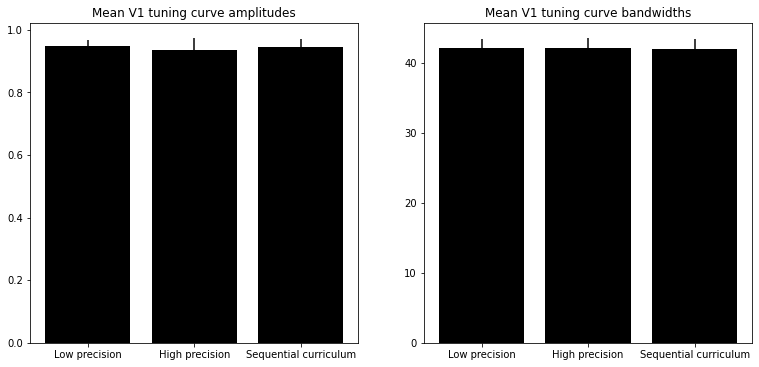

In [40]:
net.v1_tuning_params(12)
net2.v1_tuning_params(12)
net3.v1_tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v1_mean_after_amplitude, net2.v1_mean_after_amplitude, net3.v1_mean_after_amplitude], yerr = [
    net.v1_std_after_amplitude, net2.v1_std_after_amplitude, net3.v1_std_after_amplitude], color = "black");
plt.title("Mean V1 tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v1_mean_after_bandwidth, net2.v1_mean_after_bandwidth, net3.v1_mean_after_bandwidth], yerr = [
    net.v1_std_after_bandwidth, net2.v1_std_after_bandwidth, net3.v1_std_after_bandwidth], color = "black");
plt.title("Mean V1 tuning curve bandwidths");

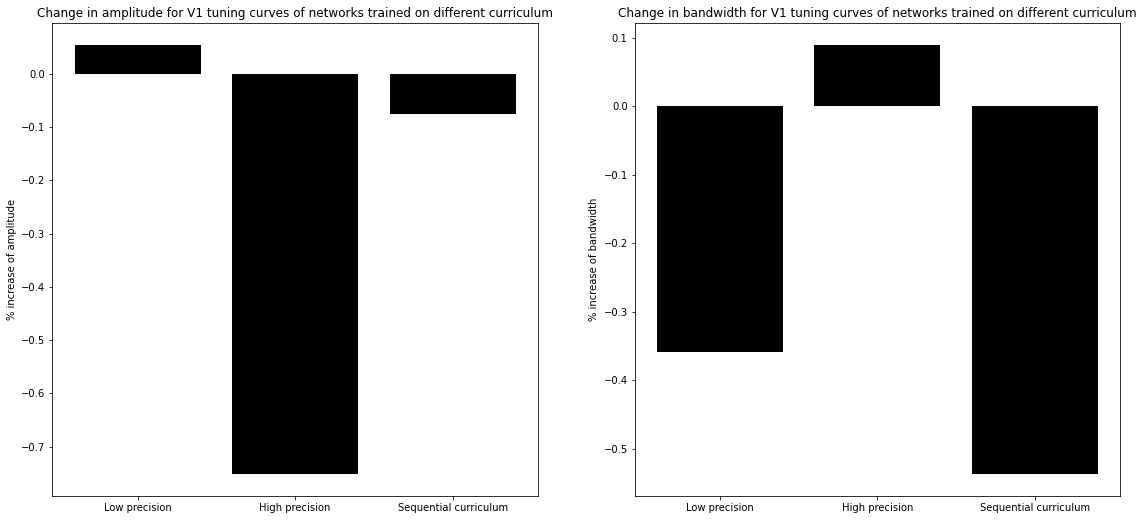

In [41]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v1_amplitude_difference, net2.v1_amplitude_difference, net3.v1_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on different curriculum");

plt.subplot(4, 4, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v1_bandwidth_difference, net2.v1_bandwidth_difference, net3.v1_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on different curriculum");

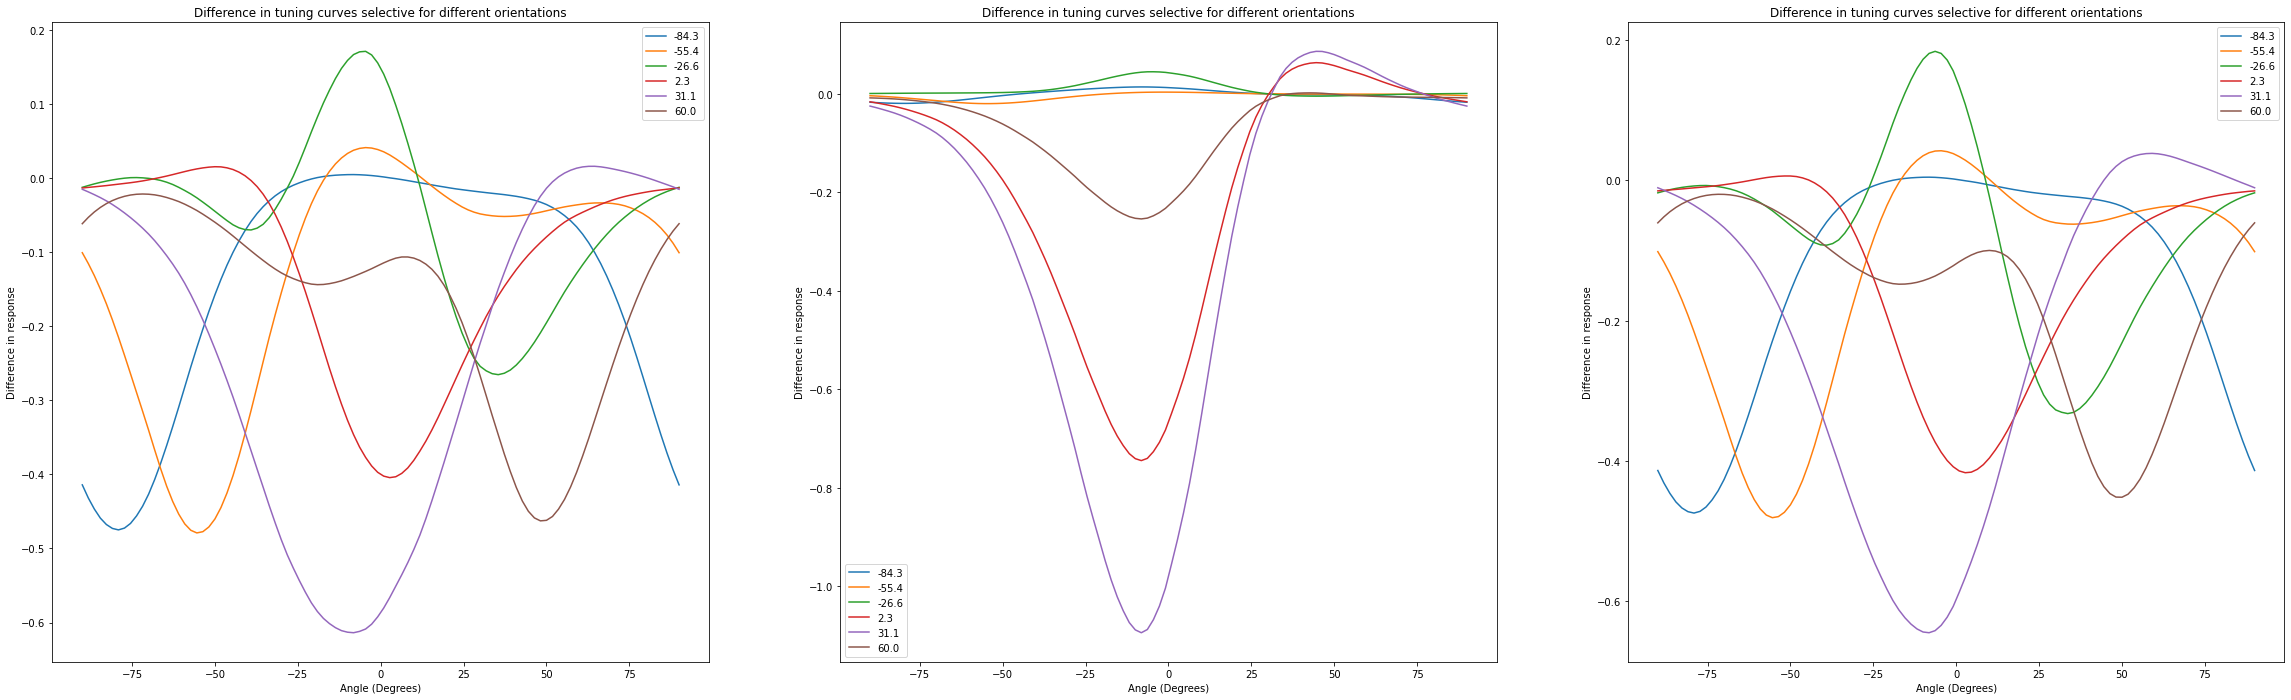

In [42]:
plt.figure(figsize = [40, 40])
plt.subplot(3, 3, 1)
net.plot_v4_tuning_curve(position = 1, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
net2.plot_v4_tuning_curve(position = 1, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 3)
net3.plot_v4_tuning_curve(position = 1, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

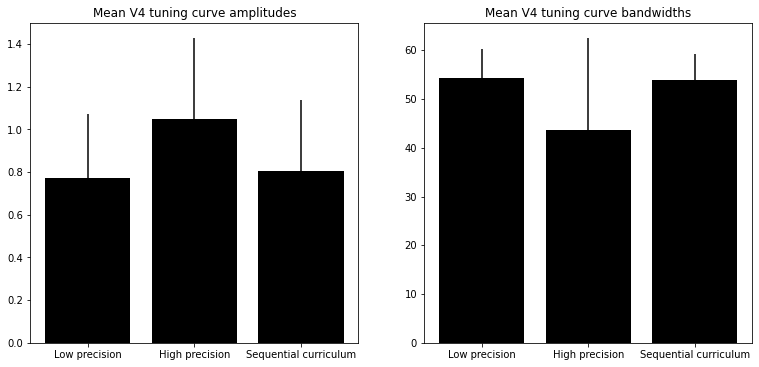

In [43]:
net.v4_tuning_params(1)
net2.v4_tuning_params(1)
net3.v4_tuning_params(1)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v4_mean_after_amplitude, net2.v4_mean_after_amplitude, net3.v4_mean_after_amplitude], yerr = [
    net.v4_std_after_amplitude, net2.v4_std_after_amplitude, net3.v4_std_after_amplitude], color = "black");
plt.title("Mean V4 tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v4_mean_after_bandwidth, net2.v4_mean_after_bandwidth, net3.v4_mean_after_bandwidth], yerr = [
    net.v4_std_after_bandwidth, net2.v4_std_after_bandwidth, net3.v4_std_after_bandwidth], color = "black");
plt.title("Mean V4 tuning curve bandwidths");

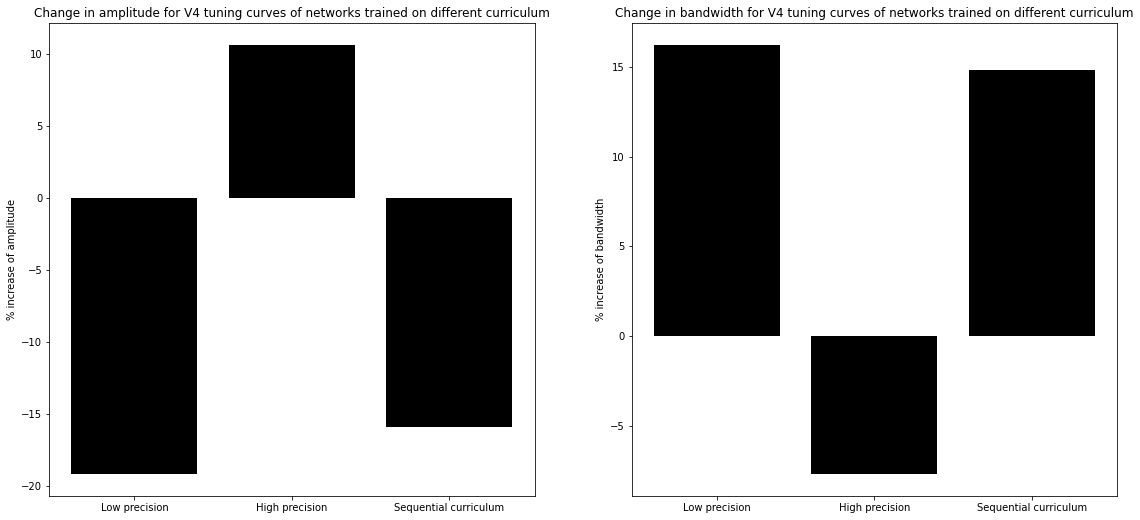

In [44]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v4_amplitude_difference, net2.v4_amplitude_difference, net3.v4_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V4 tuning curves of networks trained on different curriculum");

plt.subplot(4, 4, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.v4_bandwidth_difference, net2.v4_bandwidth_difference, net3.v4_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V4 tuning curves of networks trained on different curriculum");

## Schoups vs Ghose – Phase pooling

In [69]:
np.random.seed(2)
torch.manual_seed(2)

schoups_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
x = schoups_net.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = schoups_net.desired_outputting()
optimizer = optim.SGD(schoups_net.parameters(), lr = schoups_net.alpha)
schoups_net.mean_train(2000, optimizer)

ghose_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
x = ghose_net.inputting(-np.pi/36, np.pi/36, random_sf = True)
y = ghose_net.desired_outputting()
optimizer = optim.SGD(ghose_net.parameters(), lr = ghose_net.alpha)
ghose_net.mean_train(2000, optimizer)

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [88]:
torch.save(schoups_net.state_dict(), "Schoups_12_orientations_model.pt")
torch.save(schoups_net.losses, "Schoups_12_orientations_model_loss.pt")
torch.save(schoups_net.training_scores, "Schoups_12_orientations_model_performance.pt")
torch.save(schoups_net.before_v1weights, "Schoups_12_orientations_model_v1_weight_change.pt")
torch.save(schoups_net.before_v4weights, "Schoups_12_orientations_model_v4_weight_change.pt")
torch.save(schoups_net.before_decision_weights, "Schoups_12_orientations_model_decision_weight_change.pt")

torch.save(ghose_net.state_dict(), "Ghose_12_orientations_model.pt")
torch.save(ghose_net.losses, "Ghose_12_orientations_model_loss.pt")
torch.save(ghose_net.training_scores, "Ghose_12_orientations_model_performance.pt")
torch.save(ghose_net.before_v1weights, "Ghose_12_orientations_model_v1_weight_change.pt")
torch.save(ghose_net.before_v4weights, "Ghose_12_orientations_model_v4_weight_change.pt")
torch.save(ghose_net.before_decision_weights, "Ghose_12_orientations_model_decision_weight_change.pt")

In [92]:
schoups_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6,
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
schoups_net.load_state_dict(torch.load("Schoups_12_orientations_model.pt"))
schoups_net.losses = torch.load("Schoups_12_orientations_model_loss.pt")
schoups_net.training_scores = torch.load("Schoups_12_orientations_model_performance.pt")
schoups_net.before_v1weights = torch.load("Schoups_12_orientations_model_v1_weight_change.pt")
schoups_net.before_v4weights = torch.load("Schoups_12_orientations_model_v4_weight_change.pt")
schoups_net.before_decision_weights = torch.load("Schoups_12_orientations_model_decision_weight_change.pt")
schoups_net.v1_tuning_curve()
schoups_net.v4_tuning_curve()

ghose_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
ghose_net.load_state_dict(torch.load("Ghose_12_orientations_model.pt"))
ghose_net.losses = torch.load("Ghose_12_orientations_model_loss.pt")
ghose_net.training_scores = torch.load("Ghose_12_orientations_model_performance.pt")
ghose_net.before_v1weights = torch.load("Ghose_12_orientations_model_v1_weight_change.pt")
ghose_net.before_v4weights = torch.load("Ghose_12_orientations_model_v4_weight_change.pt")
ghose_net.before_decision_weights = torch.load("Ghose_12_orientations_model_decision_weight_change.pt")
ghose_net.v1_tuning_curve()
ghose_net.v4_tuning_curve()

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


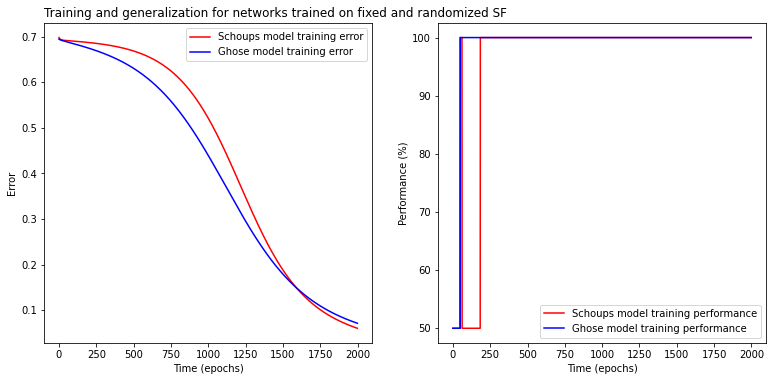

In [70]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
schoups_net.plot_training_error('red')
ghose_net.plot_training_error('blue')
plt.legend(["Schoups model training error", "Ghose model training error"]);
plt.title("Training and generalization for networks trained on fixed and randomized SF", loc = "left")

plt.subplot(3, 3, 2)
schoups_net.plot_training_performance('red')
ghose_net.plot_training_performance('blue')
plt.legend(["Schoups model training performance", "Ghose model training performance"]);



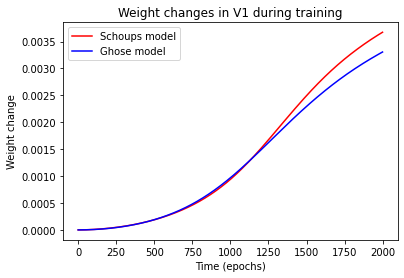

In [71]:
schoups_net.plot_weight_change('red', v1 = True)
ghose_net.plot_weight_change('blue', v1 = True)
plt.legend(["Schoups model", "Ghose model"]);
plt.title("Weight changes in V1 during training");

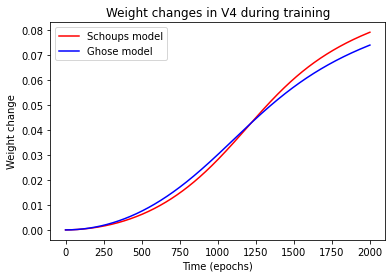

In [72]:
schoups_net.plot_weight_change('red', v4 = True)
ghose_net.plot_weight_change('blue', v4 = True)
plt.legend(["Schoups model", "Ghose model"]);
plt.title("Weight changes in V4 during training");

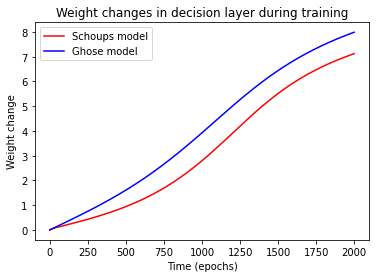

In [73]:
schoups_net.plot_weight_change('red', decision = True)
ghose_net.plot_weight_change('blue', decision = True)
plt.legend(["Schoups model", "Ghose model"]);
plt.title("Weight changes in decision layer during training");

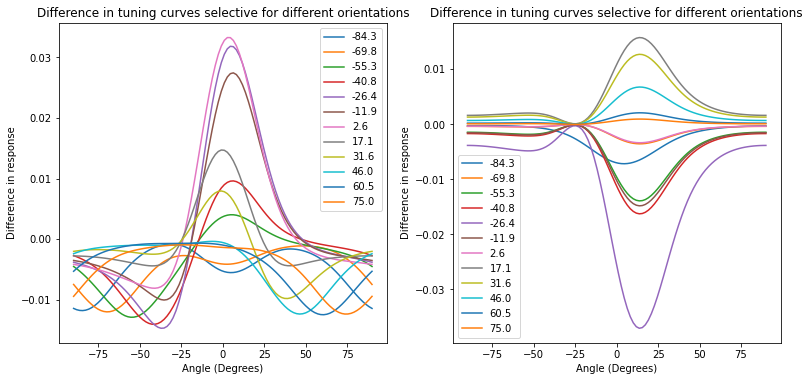

In [74]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
schoups_net.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
ghose_net.plot_v1_tuning_curve(orientation = 3, phi_sf = 0, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

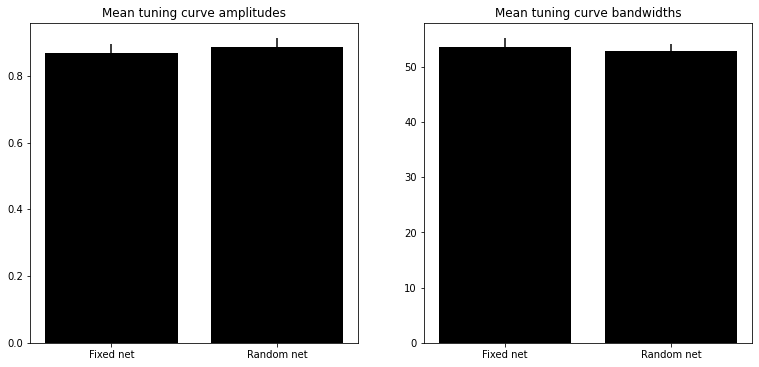

In [75]:
schoups_net.v1_tuning_params(12)
ghose_net.v1_tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Fixed net", "Random net"], [schoups_net.v1_mean_after_amplitude, ghose_net.v1_mean_after_amplitude], yerr = [
    ghose_net.v1_std_after_amplitude, ghose_net.v1_std_after_amplitude], color = "black");
plt.title("Mean tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Fixed net", "Random net"], [schoups_net.v1_mean_after_bandwidth, ghose_net.v1_mean_after_bandwidth], yerr = [
    schoups_net.v1_std_after_bandwidth, ghose_net.v1_std_after_bandwidth], color = "black");
plt.title("Mean tuning curve bandwidths");


53.48484848484849
53.52272727272727
53.06818181818182
52.87878787878788


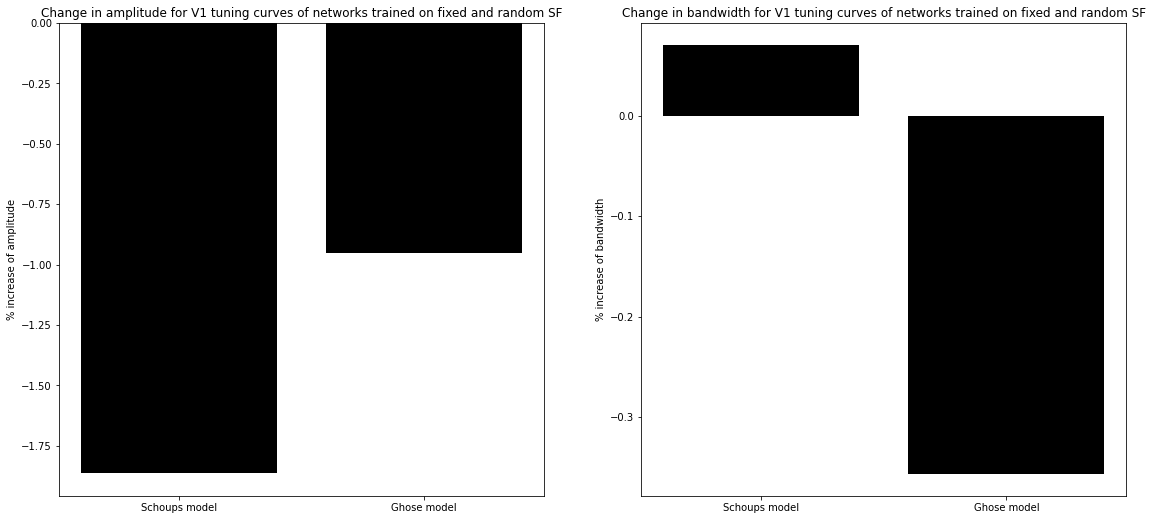

In [76]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Schoups model", "Ghose model"], [schoups_net.v1_amplitude_difference, ghose_net.v1_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on fixed and random SF");

plt.subplot(4, 4, 2)
plt.bar(["Schoups model", "Ghose model"], [schoups_net.v1_bandwidth_difference, ghose_net.v1_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on fixed and random SF");
print(schoups_net.v1_mean_before_bandwidth)
print(schoups_net.v1_mean_after_bandwidth)
print(ghose_net.v1_mean_before_bandwidth)
print(ghose_net.v1_mean_after_bandwidth)

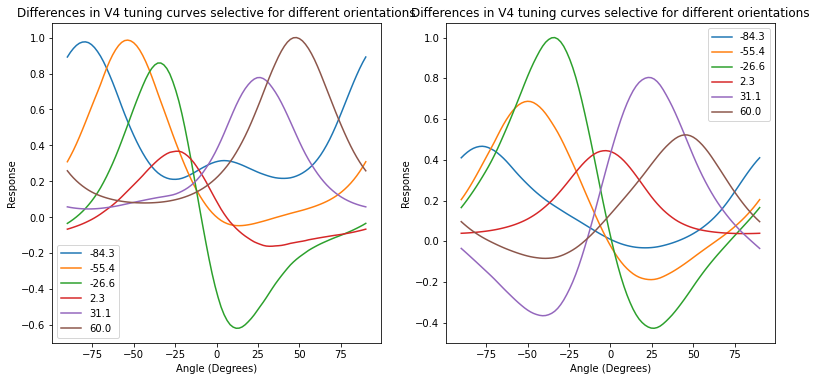

In [89]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
schoups_net.plot_v4_tuning_curve(position = 1, differences = False)
plt.title("Differences in V4 tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
ghose_net.plot_v4_tuning_curve(position = 1, differences = False)
plt.title("Differences in V4 tuning curves selective for different orientations", loc = 'center');


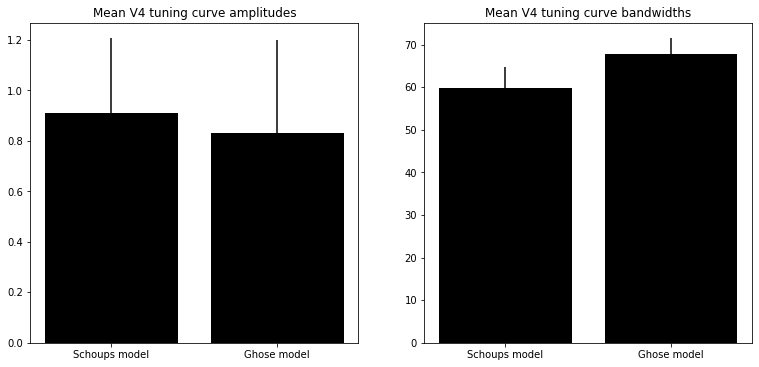

In [79]:
schoups_net.v4_tuning_params(1)
ghose_net.v4_tuning_params(1)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Schoups model", "Ghose model"], [
    schoups_net.v4_mean_after_amplitude, ghose_net.v4_mean_after_amplitude], yerr = [
    schoups_net.v4_std_after_amplitude, ghose_net.v4_std_after_amplitude], color = "black");
plt.title("Mean V4 tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Schoups model", "Ghose model"], [
    schoups_net.v4_mean_after_bandwidth, ghose_net.v4_mean_after_bandwidth], yerr = [
    schoups_net.v4_std_after_bandwidth, ghose_net.v4_std_after_bandwidth], color = "black");
plt.title("Mean V4 tuning curve bandwidths");

59.696969696969695
59.69696969696971
59.696969696969695
67.87878787878788


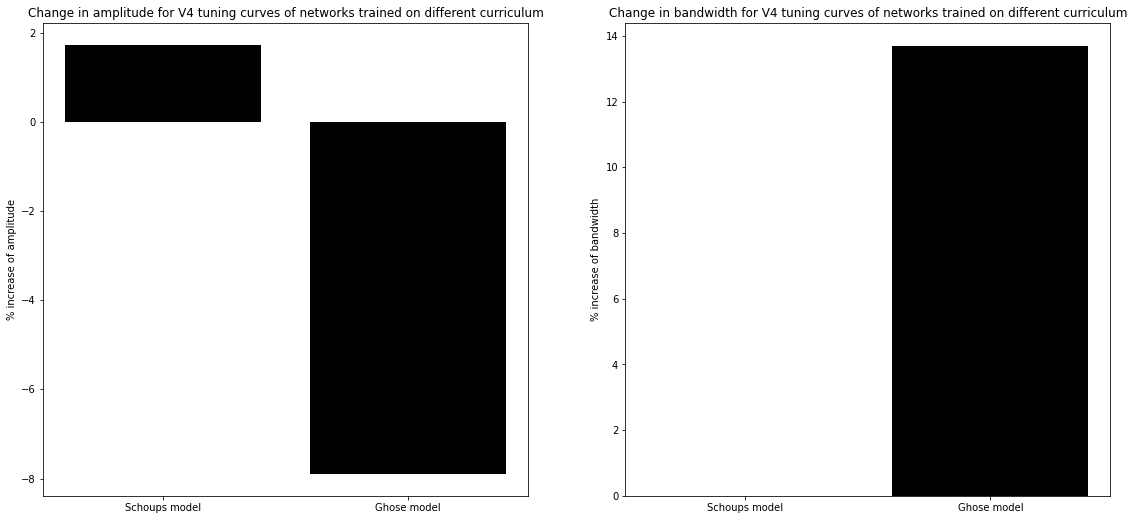

In [87]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Schoups model", "Ghose model"], [
    schoups_net.v4_amplitude_difference, ghose_net.v4_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V4 tuning curves of networks trained on different curriculum");

plt.subplot(4, 4, 2)
plt.bar(["Schoups model", "Ghose model"], [
    schoups_net.v4_bandwidth_difference, ghose_net.v4_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V4 tuning curves of networks trained on different curriculum");
print(schoups_net.v4_mean_before_bandwidth)
print(schoups_net.v4_mean_after_bandwidth)
print(ghose_net.v4_mean_before_bandwidth)
print(ghose_net.v4_mean_after_bandwidth)

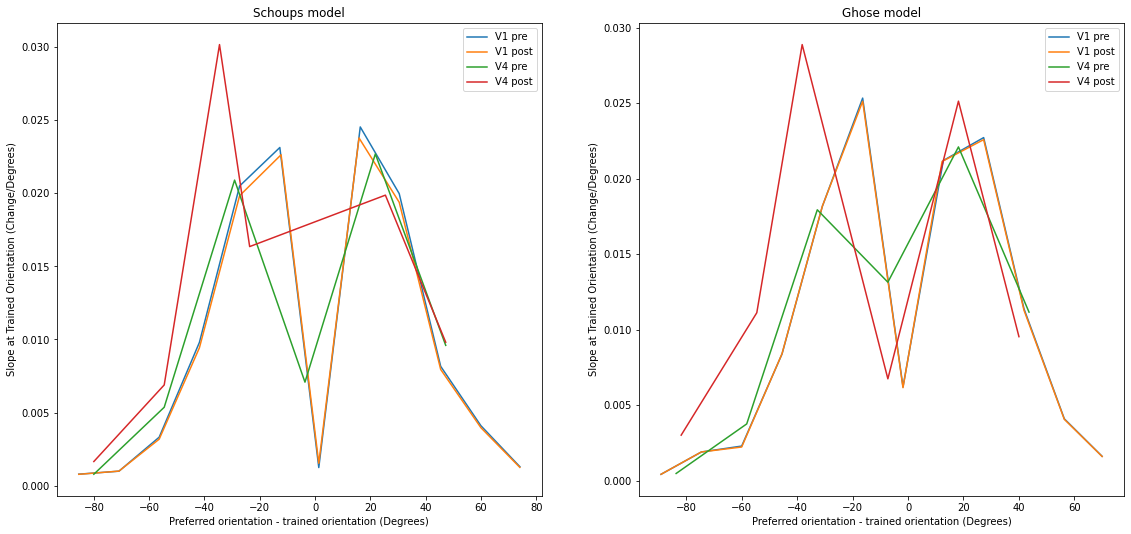

In [81]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
schoups_net.otc_curve(np.pi/180, v1_position = 12, v4_position = 1)
schoups_net.plot_otc_curve()
plt.title("Schoups model");

plt.subplot(4, 4, 2)
ghose_net.otc_curve(np.pi/36, v1_position = 12, v4_position = 1)
ghose_net.plot_otc_curve()
plt.title("Ghose model");

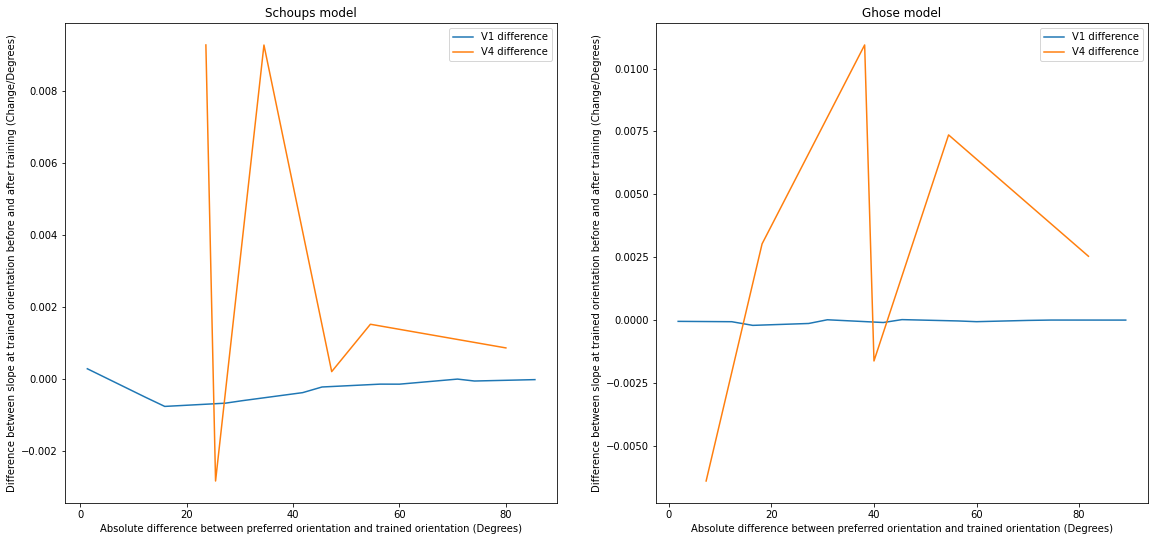

In [82]:
plt.figure(figsize = [30, 30])
plt.subplot(3, 3, 1)
schoups_net.plot_otc_curve_diff()
plt.title("Schoups model");

plt.subplot(3, 3, 2)
ghose_net.plot_otc_curve_diff()
plt.title("Ghose model");

## Fixed vs random SF

In [23]:
np.random.seed(2)
torch.manual_seed(2)

fixed_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
x = fixed_net.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = fixed_net.desired_outputting()
optimizer = optim.SGD(fixed_net.parameters(), lr = fixed_net.alpha)
fixed_net.mean_train(2000, optimizer)


random_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
x = random_net.inputting(-np.pi/180, np.pi/180, random_sf = True)
y = random_net.desired_outputting()
optimizer = optim.SGD(random_net.parameters(), lr = random_net.alpha)
random_net.mean_train(2000, optimizer)

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


In [ ]:
torch.save(fixed_net.state_dict(), "Fixed_sf_high_precision_phase_pool_model.pt")
fixed_net.losses = torch.load("Fixed_sf_high_precision_model_loss.pt")
fixed_net.training_scores = torch.load("Fixed_sf_high_precision_phase_pool_model_performance.pt")
fixed_net.before_v1weights = torch.load("Fixed_sf_high_precision_phase_pool_v1_weight_change.pt")
fixed_net.before_v4weights = torch.load("Fixed_sf_high_precision_phase_pool_model_v4_weight_change.pt")
fixed_net.before_decision_weights = torch.load("Fixed_sf_high_precision_phase_pool_model_decision_weight_change.pt")

torch.save(random_net.state_dict(), "Random_sf_high_precision_phase_pool_model.pt")
random_net.losses = torch.load("Random_sf_high_precision_model_loss.pt")
random_net.training_scores = torch.load("Random_sf_high_precision_phase_pool_model_performance.pt")
random_net.before_v1weights = torch.load("Random_sf_high_precision_phase_pool_v1_weight_change.pt")
random_net.before_v4weights = torch.load("Random_sf_high_precision_phase_pool_model_v4_weight_change.pt")
random_net.before_decision_weights = torch.load("Random_sf_high_precision_phase_pool_model_decision_weight_change.pt")

In [ ]:
fixed_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
fixed_net.load_state_dict(torch.load("Fixed_sf_high_precision_sf_pool_model.pt"))
fixed_net.v1_tuning_curve()
fixed_net.v4_tuning_curve()

random_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)
random_net.load_state_dict(torch.load("Random_sf_high_precision_sf_pool_model.pt"))
random_net.v1_tuning_curve()
random_net.v4_tuning_curve()

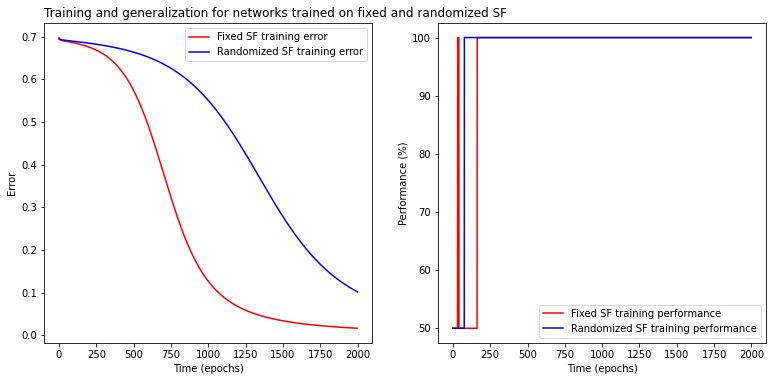

In [24]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_training_error('red')
random_net.plot_training_error('blue')
plt.legend(["Fixed SF training error", "Randomized SF training error"]);
plt.title("Training and generalization for networks trained on fixed and randomized SF", loc = "left")

plt.subplot(3, 3, 2)
fixed_net.plot_training_performance('red')
random_net.plot_training_performance('blue')
plt.legend(["Fixed SF training performance", "Randomized SF training performance"]);

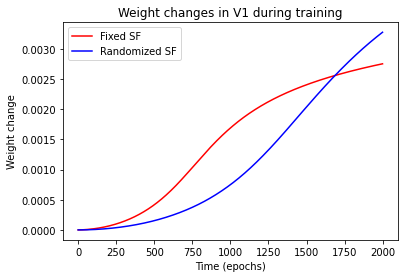

In [25]:
fixed_net.plot_weight_change('red', v1 = True)
random_net.plot_weight_change('blue', v1 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in V1 during training");

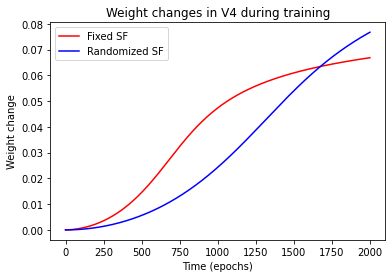

In [26]:
fixed_net.plot_weight_change('red', v4 = True)
random_net.plot_weight_change('blue', v4 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in V4 during training");

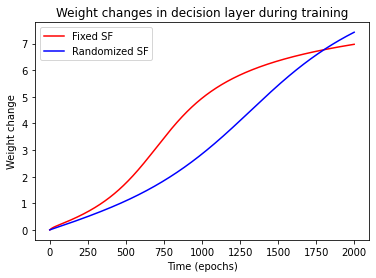

In [27]:
fixed_net.plot_weight_change('red', decision = True)
random_net.plot_weight_change('blue', decision = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in decision layer during training");

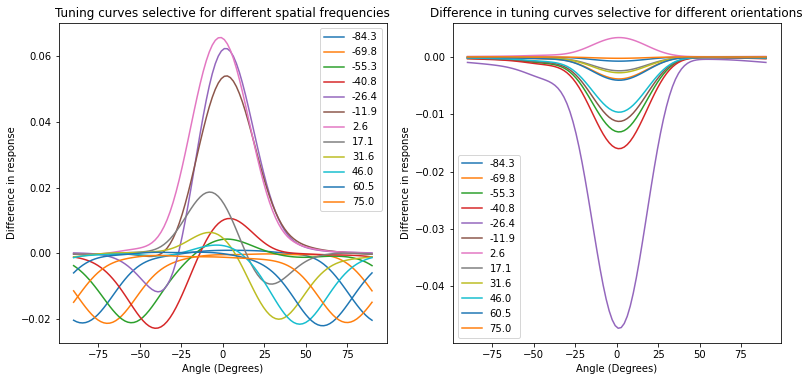

In [28]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_v1_tuning_curve(orientation = 4, phi_sf = 1, position = 12, orientations = True, differences = True)
plt.title("Tuning curves selective for different spatial frequencies", loc = 'center');

plt.subplot(3, 3, 2)
random_net.plot_v1_tuning_curve(orientation = 4, phi_sf = 1, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

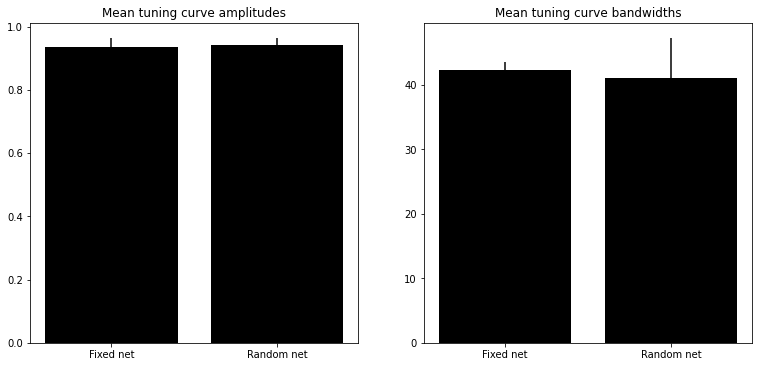

In [29]:
fixed_net.v1_tuning_params(12)
random_net.v1_tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Fixed net", "Random net"], [fixed_net.v1_mean_after_amplitude, random_net.v1_mean_after_amplitude], yerr = [
    fixed_net.v1_std_after_amplitude, random_net.v1_std_after_amplitude], color = "black");
plt.title("Mean tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Fixed net", "Random net"], [fixed_net.v1_mean_after_bandwidth, random_net.v1_mean_after_bandwidth], yerr = [
    fixed_net.v1_std_after_bandwidth, random_net.v1_std_after_bandwidth], color = "black");
plt.title("Mean tuning curve bandwidths");

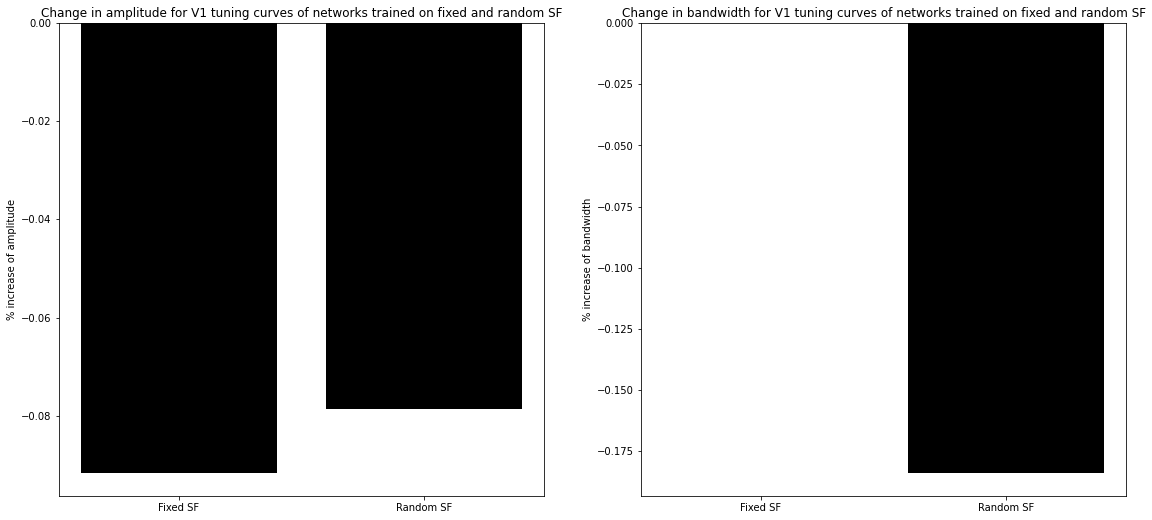

In [30]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Fixed SF", "Random SF"], [fixed_net.v1_amplitude_difference, random_net.v1_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on fixed and random SF");

plt.subplot(4, 4, 2)
plt.bar(["Fixed SF", "Random SF"], [fixed_net.v1_bandwidth_difference, random_net.v1_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on fixed and random SF");

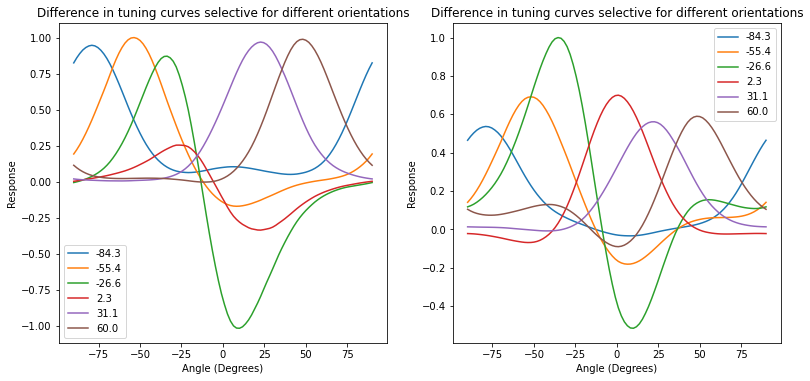

In [34]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_v4_tuning_curve(position = 1, differences = False)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
random_net.plot_v4_tuning_curve(position = 1, differences = False)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

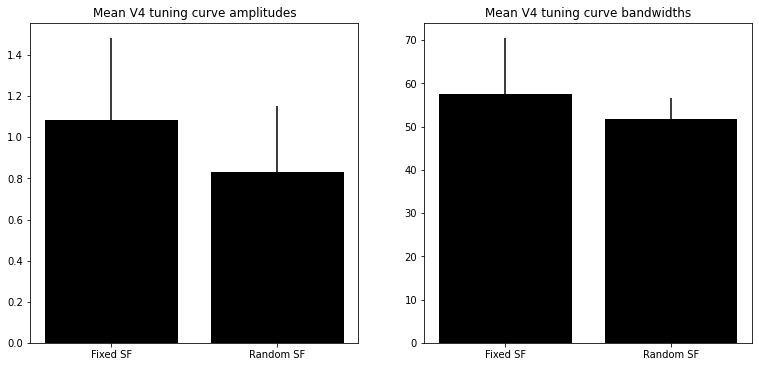

In [32]:
fixed_net.v4_tuning_params(1)
random_net.v4_tuning_params(1)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Fixed SF", "Random SF"], [
    fixed_net.v4_mean_after_amplitude, random_net.v4_mean_after_amplitude], yerr = [
    fixed_net.v4_std_after_amplitude, random_net.v4_std_after_amplitude], color = "black");
plt.title("Mean V4 tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Fixed SF", "Random SF"], [
    fixed_net.v4_mean_after_bandwidth, random_net.v4_mean_after_bandwidth], yerr = [
    fixed_net.v4_std_after_bandwidth, random_net.v4_std_after_bandwidth], color = "black");
plt.title("Mean V4 tuning curve bandwidths");

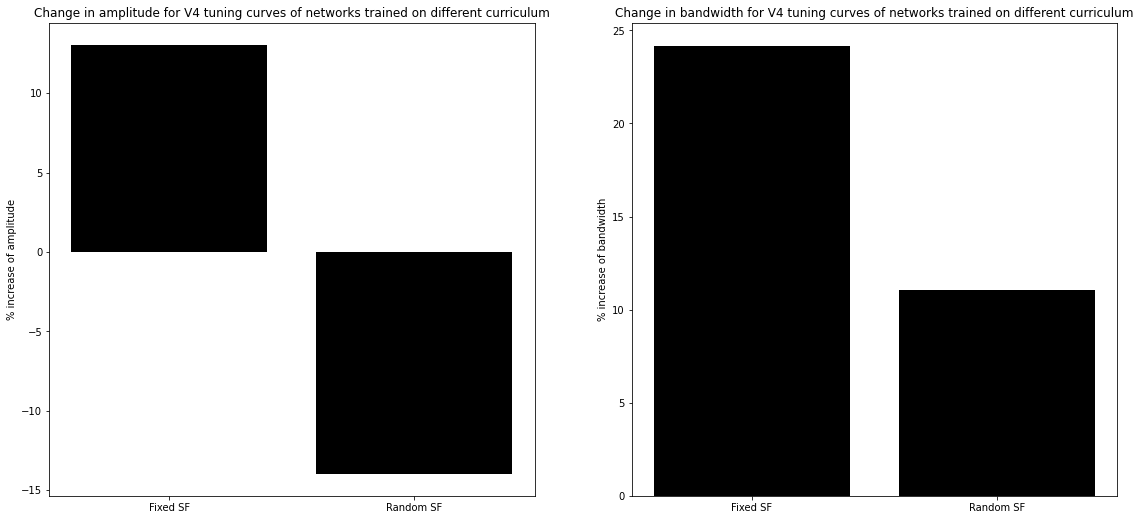

In [33]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Fixed SF", "Random SF"], [
    fixed_net.v4_amplitude_difference, random_net.v4_amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V4 tuning curves of networks trained on different curriculum");

plt.subplot(4, 4, 2)
plt.bar(["Fixed SF", "Random SF"], [
    fixed_net.v4_bandwidth_difference, random_net.v4_bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V4 tuning curves of networks trained on different curriculum");

## Random

In [ ]:
curve = fixed_net.results[1, 0, 12, 12, :]
initial_params = fixed_net.initial_tuning_curves[1, 0, 12, 12, :]
plt.plot(curve)
plt.plot(initial_params)

x = np.linspace(0, np.pi, 100)
x = (x * 180) / np.pi

def find_nearest(tensor, value):
        idx = (torch.abs(tensor - value)).argmin()
        return idx.item()

    
halfmax_amplitude = torch.abs(curve.max()) - torch.abs(curve.min())
halfmax = halfmax_amplitude/2
halfmax_index1 = find_nearest(curve, halfmax)
temporary = torch.cat([curve[0:halfmax_index1], curve[halfmax_index1+1:]])
halfmax_index2 = find_nearest(temporary, halfmax)
add = 0
while halfmax_index1-2 <= halfmax_index2 <= halfmax_index1+2:
                    temporary = torch.cat([temporary[0:halfmax_index2], temporary[halfmax_index2+1:]])
                    halfmax_index2 = find_nearest(temporary, halfmax)
                    add += 1

if halfmax_index1 < halfmax_index2:
    halfmax_index2 += 1
try1 = np.abs(x[halfmax_index1] - x[halfmax_index2])
try2 = 180 - np.abs(x[halfmax_index1] - x[halfmax_index2])
if try1 < try2:
    bandwidth = try1
else:
    bandwidth = try2



halfmax2_amplitude2 = torch.abs(initial_params.max()) - torch.abs(initial_params.min())
halfmax2 = halfmax2_amplitude2/2
halfmax2_index1 = find_nearest(initial_params, halfmax2)
temporary2 = torch.cat([initial_params[0:halfmax2_index1], initial_params[halfmax2_index1+1:]])
halfmax2_index2 = find_nearest(temporary2, halfmax2)
add = 0
while halfmax2_index1-2 <= halfmax2_index2 <= halfmax2_index1+2:
                    temporary = torch.cat([temporary[0:halfmax2_index2], temporary[halfmax2_index2+1:]])
                    halfmax2_index2 = find_nearest(temporary, halfmax2)
                    add += 1
if halfmax2_index1 < halfmax2_index2:
    halfmax2_index2 += 1
try1 = np.abs(x[halfmax2_index1] - x[halfmax2_index2])
try2 = 180 - np.abs(x[halfmax2_index1] - x[halfmax2_index2])
if try1 < try2:
    bandwidth2 = try1
else:
    bandwidth2 = try2

bandwidth, bandwidth2
halfmax, halfmax_index1, halfmax_index2, halfmax2_index1


In [ ]:
print(fixed_net.before_bandwidths == fixed_net.after_bandwidths)

In [ ]:
print(fixed_net.initial_tuning_curves[0][0][12][12][:]) 
print(random_net.initial_tuning_curves[0][0][12][12][:])

In [ ]:
for i in fixed_net.parameters():
    print(i)

In [ ]:
input = torch.rand(1, 1, 5, 5)
weight = torch.randn(1, 4, 1, 4, 4, 2**2)
input

In [ ]:
weight.shape

In [ ]:
output = input.unfold(2, 2, 2).unfold(3, 2, 2)
output2 = output.contiguous().view(*output.size()[:-2],-1)
output2

In [ ]:
out = (output2.unsqueeze(1) * weight).sum([2,-1])
a = []
for i in range(0, 4, 2):
    a.append(torch.sum(out[0][i:i+2] ** 2, dim = 0))
out, torch.stack(a).view(2, 4, 4)

In [ ]:
weight.sum([2,-1])

In [ ]:
def generate_gabor(size, theta):
    ksize = size
    sigma = 3
    lamda = 5
    gamma = 0.5
    phi = 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    return torch.tensor(kernel).view(1, 1, size, size).float()

angles = np.linspace(0, np.pi, 6)
weights = []
for i in range(6):
    for j in range(49):
        theta = angles[i]
        kernel = generate_gabor(5, theta)
        weights.append(kernel)
weight = torch.stack(weights).view(1, 6, 1, 7, 7, 25)
weights

In [ ]:

inputs = []

x = np.linspace(0, np.pi, 10)

for i in range(1):
    theta = x[i]
    kernel = generate_gabor(11, theta)
    inputs.append(kernel)

input = torch.stack(inputs).view(1, 1, 11, 11)
output = input.unfold(2, 5, 1).unfold(3, 5, 1)
output2 = output.contiguous().view(*output.size()[:-2],-1)
out = (output2.unsqueeze(1) * weight).sum([2,-1])
output2.shape

In [ ]:
x = np.linspace(0, 7, 6)
np.delete(x, -1)
x

In [ ]:
np.linspace(0, np.pi, 3), np.pi/2

In [ ]:
m = nn.MaxPool2d((2,2), stride = (2,2))
input = torch.rand(1, 1, 5, 5)
input, m(input)

In [ ]:
for i in range(0, 10, 2):
    print(i)

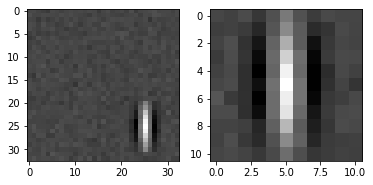

In [54]:
fig, [ax1, ax2] = plt.subplots(1, 2)
ksize = 11
sigma = 1.6
lamda = 5
gamma = 0.5
phi = 0
theta = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
kernel = torch.tensor(kernel)
noise = torch.normal(0, 0.03, (33,33))
x_location = 20
y_location = 20
for i in range(ksize):
    for j in range(ksize):
        noise[i + x_location][j + y_location] = kernel[i][j] + noise[i + x_location][j + y_location]
ax1.imshow(noise, 'gray')

ksize = 11
sigma = 1.5
lamda = 5
gamma = 0.5
phi = 0
theta = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
kernel = torch.tensor(kernel)
noise = torch.normal(0, 0.03, (11, 11))
kernel = kernel+ noise
ax2.imshow(kernel, 'gray')

In [55]:
def gaussian(M, std):
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    return w

def gkern(kernlen=256, std=128):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian(kernlen, std=std).reshape(kernlen)
    gkern2d = torch.outer(gkern1d, gkern1d)
    return gkern2d

def gkern_1d(kernlen=256, std=128):
    """Returns a 1D Gaussian kernel array."""
    gkern1d = gaussian(kernlen, std=std).reshape(kernlen)
    return gkern1d

# # Test plot
# plt.figure()
# plt.imshow(gkern(11, std=2), 'gray')
# plt.show()
a = (gkern(11, 2),)*5
b = torch.stack(a)
scale = gkern_1d(5, 2)
scales = torch.empty(5, 11, 11)
for i in range(5):
    scales[i] = b[i] * scale[i]
scales.shape

torch.Size([5, 11, 11])

In [56]:
# input number: 1, input size: 3x3, weight size: 2x2, weight number 2
x = torch.rand(1, 3, 3)
weight = torch.rand(1, 2, 2, 4)
y = x.unfold(1, 2, 1).unfold(2, 2, 1)
z = y.contiguous().view(*y.size()[:-2], -1)
out = (z.unsqueeze(1)*weight).sum([1, -1])
out.shape

torch.Size([1, 2, 2])

In [ ]:

def random():
    
    x = np.random.rand(1)
    y = torch.rand(1)
    return x, y


In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random()

In [ ]:
device = torch.device('cuda')
device

In [ ]:
torch.manual_seed(0)
x = torch.rand(11)
halfmax = x.max()/2

def find_nearest(tensor, value):
    idx = (torch.abs(tensor - value)).argmin()
    return idx
a = find_nearest(x, halfmax)
temporary = torch.cat([x[0:a], x[a+1:]])
x[a], x[find_nearest(temporary, halfmax)]

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda:0")
device

In [ ]:
torch.cuda.device_count()

In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [ ]:
a = np.random.rand(5)
b = range(5)
plt.plot(a)
plt.errorbar(b, a, xerr = a.std(), yerr = a.std())
a.mean()

In [ ]:
a = torch.tensor([-1.2, -2, -3, -4, 0.2, 0.3])
(torch.abs(a.max())-torch.abs(a.min()))/2

In [ ]:
torch.manual_seed(0)
x = torch.empty((6, 3, 3, 100))
for i in range(100):
    y = torch.rand((6, 3, 3))
    x[:, :, :, i] = y
x

In [ ]:
F.relu(torch.tensor(-2))

In [ ]:
x = [1, 2, 3, 4]
y = torch.tensor(x)
y

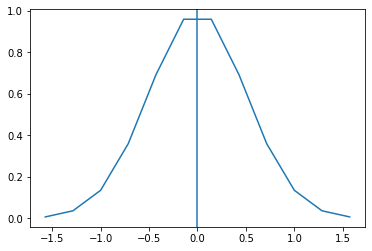

In [46]:
M = 12
mean = 0
std = 0.5
n = torch.linspace(-np.pi/2, np.pi/2, M) - mean
sig2 = 2 * std * std
w = torch.exp(-n ** 2 / sig2)
plt.plot(np.linspace(-np.pi/2, np.pi/2, M), w);
plt.axvline(0)

In [23]:
v4_weight = torch.rand(12, 3, 3, 12, 121)
pools = torch.rand(12, 23, 23)
out = pools.unfold(1, 11, 6).unfold(2, 11, 6)
out = out.contiguous().view(*out.size()[:-2], -1)
# out = (out.unsqueeze(1)*v4_weight).sum([1, -1])
out.shape

torch.Size([12, 3, 3, 121])

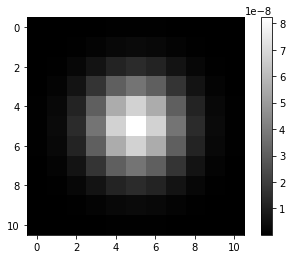

In [45]:
plt.imshow(schoups_net.generate_3d_gaussian(-np.pi/2, 0.5)[10], 'gray')
plt.colorbar()

In [67]:
a = torch.rand(3, 2, 2)
a, a.sum(1), a.sum([1, -1])
c = a.sum([1, -1]).sum(0)
d = a.sum([1, -1, 0])
c==d

tensor(True)

In [76]:
a = torch.rand(5, 1, 3, 3, 6)
b = torch.rand(5, 3, 3, 6)
a, b, (a*b)

(tensor([[[[[0.1206, 0.1730, 0.1067, 0.3099, 0.2835, 0.7641],
            [0.1191, 0.5831, 0.0121, 0.0385, 0.8917, 0.0929],
            [0.8891, 0.1876, 0.2011, 0.3396, 0.8272, 0.7525]],
 
           [[0.3720, 0.2546, 0.1567, 0.4739, 0.4136, 0.1782],
            [0.3074, 0.5037, 0.6242, 0.1007, 0.3446, 0.5486],
            [0.7189, 0.4050, 0.6605, 0.3974, 0.9037, 0.5927]],
 
           [[0.8303, 0.4727, 0.7806, 0.1067, 0.4121, 0.8867],
            [0.8961, 0.6261, 0.3349, 0.2441, 0.6209, 0.3306],
            [0.2619, 0.3712, 0.8269, 0.8975, 0.4457, 0.9060]]]],
 
 
 
         [[[[0.8815, 0.0934, 0.4066, 0.4608, 0.8875, 0.1020],
            [0.2339, 0.2426, 0.5514, 0.0736, 0.6340, 0.2395],
            [0.3268, 0.2621, 0.0305, 0.3861, 0.6307, 0.9711]],
 
           [[0.8817, 0.3731, 0.9159, 0.1443, 0.4958, 0.0305],
            [0.7569, 0.8030, 0.9021, 0.2351, 0.4226, 0.8776],
            [0.4875, 0.4022, 0.2659, 0.0255, 0.8092, 0.3308]],
 
           [[0.6482, 0.9709, 0.1122, 0.0594, 0.31

In [55]:
a = torch.rand(2, 1, 2)
b = torch.rand(2, 2)
a, b, (a*b)

(tensor([[[0.3146, 0.5812]],
 
         [[0.7717, 0.5912]]]),
 tensor([[0.2407, 0.3305],
         [0.5656, 0.9599]]),
 tensor([[[0.0757, 0.1921],
          [0.1780, 0.5579]],
 
         [[0.1858, 0.1954],
          [0.4365, 0.5675]]]))

In [61]:
torch.tensor([1, 2, 3]) == torch.tensor([1, 2, 3])

tensor([True, True, True])

In [89]:
schoups_net.v4_weight.shape

torch.Size([6, 12, 3, 3, 121])

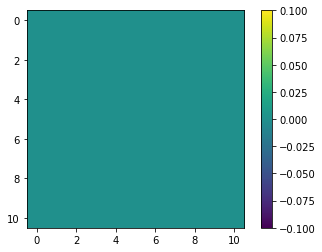

In [96]:
net4 = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.1)

plt.imshow(net4.v4_weight[0][10][1][1].view(11, 11).detach().numpy())
plt.colorbar();
# net.v4_weight[5][0][1][1].view(11, 11)


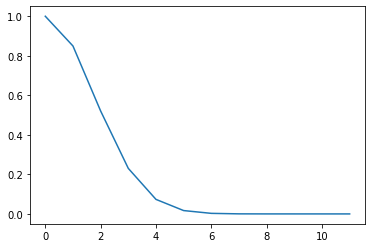

In [142]:
plt.plot(schoups_net.generate_gaussian(-np.pi/2, 0.5, 12))

In [140]:
test_net = LCN_model.LCN(
    input_size = 33, simple_number = 12, simple_size = 11, v4_size = 11, v4_stride = 6, v4_orientation_number = 6, 
    phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.01)

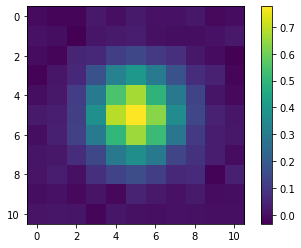

In [141]:

plt.imshow(test_net.v4_weight[0][0][1][1].view(11, 11).detach().numpy())
plt.colorbar();
# test_net.v4_weight[5][0][1][1].view(11, 11)

(0.0, 5.0)

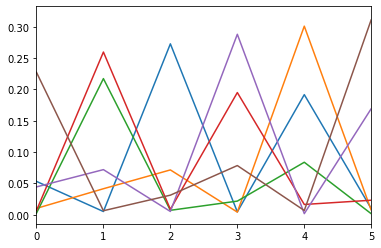

In [136]:
for i in range(6):
    plt.plot(schoups_net.v4_initial_tuning_curves[i][1][1][:]);
plt.xlim(0, 5)

In [36]:
schoups_net.v4_results[3][1][1]

tensor([0.0100, 0.0104, 0.0110, 0.0116, 0.0121, 0.0126, 0.0130, 0.0135, 0.0140,
        0.0144, 0.0148, 0.0154, 0.0160, 0.0168, 0.0175, 0.0184, 0.0195, 0.0209,
        0.0227, 0.0249, 0.0275, 0.0309, 0.0349, 0.0396, 0.0453, 0.0520, 0.0598,
        0.0687, 0.0790, 0.0906, 0.1036, 0.1180, 0.1339, 0.1511, 0.1695, 0.1888,
        0.2089, 0.2293, 0.2497, 0.2698, 0.2892, 0.3075, 0.3244, 0.3394, 0.3524,
        0.3631, 0.3710, 0.3762, 0.3788, 0.3782, 0.3745, 0.3677, 0.3581, 0.3459,
        0.3316, 0.3150, 0.2967, 0.2773, 0.2569, 0.2359, 0.2146, 0.1937, 0.1733,
        0.1538, 0.1355, 0.1185, 0.1029, 0.0889, 0.0763, 0.0653, 0.0557, 0.0475,
        0.0404, 0.0344, 0.0295, 0.0255, 0.0221, 0.0192, 0.0169, 0.0149, 0.0131,
        0.0117, 0.0106, 0.0097, 0.0090, 0.0084, 0.0080, 0.0078, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0078, 0.0081, 0.0085, 0.0088, 0.0091, 0.0094, 0.0096,
        0.0100])

tensor([0.0000e+00, 1.3587e-36, 2.0079e-22, 8.5109e-12, 1.0346e-04, 3.6074e-01,
        3.6074e-01, 1.0346e-04, 8.5109e-12, 2.0079e-22, 1.3587e-36, 0.0000e+00])

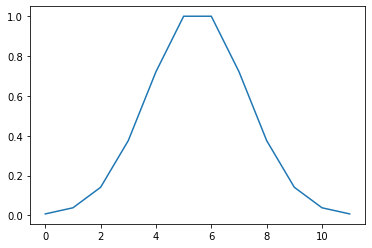

In [15]:
plt.plot(schoups_net.generate_gaussian(0, 0.5, 12) / torch.max(schoups_net.generate_gaussian(0, 0.5, 12)))
schoups_net.generate_gaussian(0, 0.1, 12)

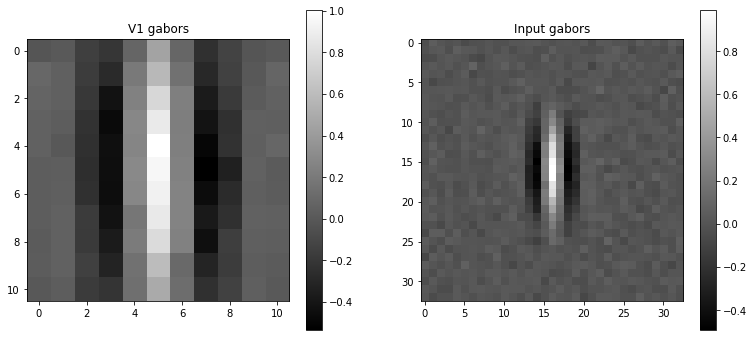

In [137]:
plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)

kernel = schoups_net.generate_gabor(11, 0, 0, 5).view(11, 11)
noise = torch.normal(0, 0.03, (11, 11))
kernel = kernel+noise
plt.imshow(kernel, 'gray')
plt.colorbar()
plt.title("V1 gabors");

plt.subplot(3, 3, 2)

kernel = schoups_net.generate_gabor(33, 0, 0, 5).view(33, 33)
noise = torch.normal(0, 0.03, (33, 33))
kernel = kernel+noise
plt.imshow(kernel, 'gray')
plt.colorbar()
plt.title("Input gabors");


In [122]:
a = [-1, 2, -3]
np.abs(a)

array([1, 2, 3])

In [138]:
list1 = schoups_net.v1_after_range
list2 = schoups_net.v1_mean_after_slopes

list1 = np.abs(list1)
zipped_lists = zip(list1, list2)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
list1, list2 = [ list(tuple) for tuple in  tuples]

print(list1, list2)
print(schoups_net.v1_after_range, schoups_net.v1_mean_after_slopes)

[1.3636363636363589, 12.27272727272728, 16.363636363636356, 27.27272727272727, 30.90909090909091, 41.81818181818183, 45.45454545454545, 56.363636363636374, 59.999999999999986, 70.90909090909092, 74.09090909090908, 85.45454545454545] [0.017532044716062956, 0.28416355699300766, 0.298721369355917, 0.22301754355430603, 0.20637335628271103, 0.06608754303306341, 0.049582792446017265, 0.01077596953837201, 0.018909168313257396, 0.0013320893340278417, 0.005083951429696754, 0.005331748980097473]
[-85.45454545454545, -70.90909090909092, -56.363636363636374, -41.81818181818183, -27.27272727272727, -12.27272727272728, 1.3636363636363589, 16.363636363636356, 30.90909090909091, 45.45454545454545, 59.999999999999986, 74.09090909090908] [0.005331748980097473, 0.0013320893340278417, 0.01077596953837201, 0.06608754303306341, 0.22301754355430603, 0.28416355699300766, 0.017532044716062956, 0.298721369355917, 0.20637335628271103, 0.049582792446017265, 0.018909168313257396, 0.005083951429696754]


In [50]:
x = torch.rand(2, 2, 2, 3, 3)
x[:, 1, :, :, :], x[:, 1]

(tensor([[[[0.2214, 0.0888, 0.1898],
           [0.4218, 0.3395, 0.7172],
           [0.0846, 0.7793, 0.1001]],
 
          [[0.9388, 0.2238, 0.1105],
           [0.9174, 0.0680, 0.8473],
           [0.0847, 0.1975, 0.5434]]],
 
 
         [[[0.2696, 0.0720, 0.7654],
           [0.4787, 0.3813, 0.5364],
           [0.5396, 0.2821, 0.8393]],
 
          [[0.3641, 0.3004, 0.0889],
           [0.0920, 0.2244, 0.9755],
           [0.7412, 0.6436, 0.5692]]]]),
 tensor([[[[0.2214, 0.0888, 0.1898],
           [0.4218, 0.3395, 0.7172],
           [0.0846, 0.7793, 0.1001]],
 
          [[0.9388, 0.2238, 0.1105],
           [0.9174, 0.0680, 0.8473],
           [0.0847, 0.1975, 0.5434]]],
 
 
         [[[0.2696, 0.0720, 0.7654],
           [0.4787, 0.3813, 0.5364],
           [0.5396, 0.2821, 0.8393]],
 
          [[0.3641, 0.3004, 0.0889],
           [0.0920, 0.2244, 0.9755],
           [0.7412, 0.6436, 0.5692]]]]))

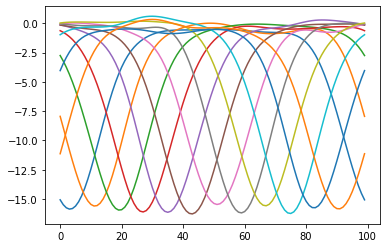

In [90]:
for i in range(schoups_net.simple_number):
    plt.plot(schoups_net.initial_tuning_curves[i, 1, 12, 12, :])

In [43]:
for i in range(3, 20, 2):
    print(i)

3
5
7
9
11
13
15
17
19
